## VIT Model

In [1]:
#!pip install --upgrade tensorflow==2.13
#!pip install vit_keras
#!pip install keras
#!pip install --upgrade tensorflow-addons
#!pip install scikit-learn
#!pip show scikit-learn  # show scikit-learn version and location
#!pip freeze             # show all installed packages in the environment
#!pip install seaborn
import sklearn
#sklearn.show_versions()

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow_addons as tfa
import glob, random, os, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print('TensorFlow Version ' + tf.__version__)

def seed_everything(seed = 0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything()

import warnings
warnings.filterwarnings("ignore")

C:\Users\joshu\miniforge3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


TensorFlow Version 2.13.0


In [16]:
import tensorflow as tf

# Define parameters
batch_size = 32
img_height = 256
img_width = 256
data_dir = 'Plant Disease(Potato)'

# Load and preprocess the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Access class names
class_names = train_ds.class_names
print(f"Class names: {class_names}")


Found 2152 files belonging to 3 classes.
Using 1722 files for training.
Class names: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [41]:
# Load the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Access and print class names
class_names = train_ds.class_names
print(f"Class names: {class_names}")
# Normalize pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)

def preprocess(image, label):
    image = normalization_layer(image)
    return image, label

train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)

# Optionally, cache and prefetch to optimize performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# Inspect dataset
for image_batch, label_batch in train_ds.take(1):
    print(f"Image batch shape: {image_batch.shape}")
    print(f"Label batch shape: {label_batch.shape}")
    print(f"Labels: {label_batch.numpy()}")


Found 2152 files belonging to 3 classes.
Using 1722 files for training.
Found 2152 files belonging to 3 classes.
Using 430 files for validation.
Class names: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
Image batch shape: (32, 256, 256, 3)
Label batch shape: (32,)
Labels: [0 0 0 0 1 2 1 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 1 1 2 1 1 1 0 0 0]


In [42]:
for image_batch, label_batch in train_ds.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


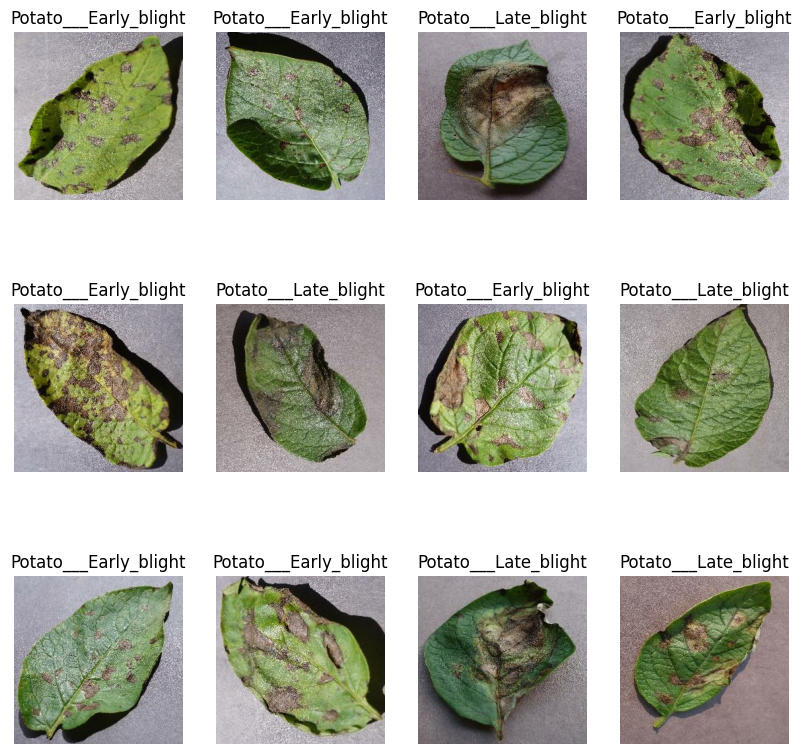

In [43]:
import matplotlib.pyplot as plt

# Create a figure with a specific size
plt.figure(figsize=(10, 10))

# Fetch a batch of images and labels from the dataset
for image_batch, label_batch in train_ds.take(1):
    # Loop through the first 12 images in the batch
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        # Scale image data to [0, 255] and convert to uint8
        img = (image_batch[i] * 255).numpy().astype('uint8')
        plt.imshow(img)
        plt.title(class_names[label_batch[i].numpy()])
        plt.axis('off')

# Display the figure
plt.show()


## Build Model

In [36]:
#!pip install --upgrade vit-keras

In [37]:
#!pip install opencv-python

In [44]:
def build_vit_model(img_height, img_width, num_classes, patch_size=16, embed_dim=64, num_heads=4, ff_dim=128, num_blocks=4):
    inputs = Input(shape=(img_height, img_width, 3))
    x = PatchExtract(patch_size)(inputs)
    x = Dense(embed_dim)(x)
    
    for _ in range(num_blocks):
        x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
    
    x = tf.reduce_mean(x, axis=1)  # Global average pooling
    x = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=x)
    return model

# Build the model
vit_model = build_vit_model(img_height, img_width, num_classes=4, patch_size=16, embed_dim=64, num_heads=4, ff_dim=128, num_blocks=4)

# Compile the model
vit_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


NameError: name 'Input' is not defined

In [39]:
class Patches(L.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

<Figure size 400x400 with 0 Axes>

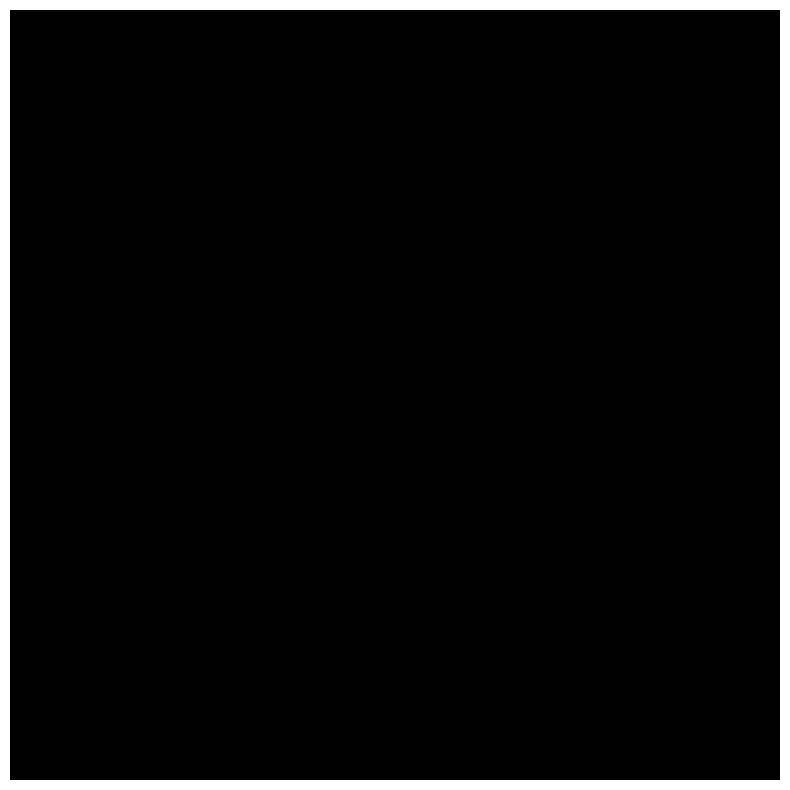

ValueError: 'size' must be a 1-D Tensor of 2 elements: new_height, new_width

In [40]:
plt.figure(figsize=(4, 4))
batch_size = 32
patch_size = 7  # Size of the patches to be extract from the input images
img_height = 256
num_patches = (img_height // patch_size) ** 2

# Create an iterator from the dataset
dataset_iterator = iter(train_ds)

# Fetch the next batch
x = next(dataset_iterator)

image = x[0][0]

# Convert TensorFlow tensor to NumPy array
image_np = image.numpy().astype('uint8')

# Plot the image
plt.figure(figsize=(10, 10))
plt.imshow(image_np)
plt.axis('off')
plt.show()

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size = (image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f'Image size: {image_size} X {image_size}')
print(f'Patch size: {patch_size} X {patch_size}')
print(f'Patches per image: {patches.shape[1]}')
print(f'Elements per patch: {patches.shape[-1]}')

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))

for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype('uint8'))
    plt.axis('off')